In [80]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from pathlib import Path
import shutil

# Video Prep

In [2]:
from pytubefix import YouTube
from pytubefix.cli import on_progress

In [55]:
video_url = 'https://www.youtube.com/watch?v=C4dCPdK88q8'
video_url = 'https://www.youtube.com/watch?v=K17df81RL9Y'

yt = YouTube(
    video_url,
    on_progress_callback=on_progress,
    #use_oauth=True,
    #allow_oauth_cache=False
)
stream = yt.streams.filter(progressive=True, file_extension="mp4").get_highest_resolution()

# Initialize progress bar and download the video.
temp_video_path = stream.download(skip_existing=False) # Download the video.

# Ensure output directory exists.
outputs_dir = Path('./img/008-videos/')
outputs_dir.mkdir(parents=True, exist_ok=True)

video = Path(temp_video_path)
new_video_path = outputs_dir / video.name
shutil.move(str(video), str(new_video_path))

 ↳ |████████████████████████████████████████████| 100.0%

'img/008-videos/AURORA - Cure For Me.mp4'

In [56]:
from IPython.display import Video

In [57]:
Video(new_video_path, width=500, height=300)

In [67]:
cap = cv.VideoCapture(new_video_path)
    
if not cap.isOpened():
    raise ValueError(f"Error: Could not open video file {video_path}")

total_frames = cap.get(cv.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv.CAP_PROP_FPS)

print(f'total frames={total_frames}. fps={fps}')
print(total_frames / fps)

cap.release()

total frames=5038.0. fps=25.0
201.52


In [70]:
# Read 'till we get to about were we care...
desired_frame_start = (10 * fps)
desired_frame_end = desired_frame_start + (2*fps)
current_frame = 0

print(f'reading until frame {desired_frame}')

frames_of_interest = []

cap = cv.VideoCapture(new_video_path)
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True.
    if not ret:
        raise ValueError('can\'t read any ore frames. we may have reached the end')
    else:
        current_frame += 1

    if desired_frame_start < current_frame <= desired_frame_end:
        print(f'{desired_frame_start} < {current_frame} <= {desired_frame_end}')
        frames_of_interest.append(frame)
        
    if current_frame > desired_frame_end:
        break

cap.release()


len(frames_of_interest), frames_of_interest[0].shape

reading until frame 400.0
250.0 < 251 <= 300.0
250.0 < 252 <= 300.0
250.0 < 253 <= 300.0
250.0 < 254 <= 300.0
250.0 < 255 <= 300.0
250.0 < 256 <= 300.0
250.0 < 257 <= 300.0
250.0 < 258 <= 300.0
250.0 < 259 <= 300.0
250.0 < 260 <= 300.0
250.0 < 261 <= 300.0
250.0 < 262 <= 300.0
250.0 < 263 <= 300.0
250.0 < 264 <= 300.0
250.0 < 265 <= 300.0
250.0 < 266 <= 300.0
250.0 < 267 <= 300.0
250.0 < 268 <= 300.0
250.0 < 269 <= 300.0
250.0 < 270 <= 300.0
250.0 < 271 <= 300.0
250.0 < 272 <= 300.0
250.0 < 273 <= 300.0
250.0 < 274 <= 300.0
250.0 < 275 <= 300.0
250.0 < 276 <= 300.0
250.0 < 277 <= 300.0
250.0 < 278 <= 300.0
250.0 < 279 <= 300.0
250.0 < 280 <= 300.0
250.0 < 281 <= 300.0
250.0 < 282 <= 300.0
250.0 < 283 <= 300.0
250.0 < 284 <= 300.0
250.0 < 285 <= 300.0
250.0 < 286 <= 300.0
250.0 < 287 <= 300.0
250.0 < 288 <= 300.0
250.0 < 289 <= 300.0
250.0 < 290 <= 300.0
250.0 < 291 <= 300.0
250.0 < 292 <= 300.0
250.0 < 293 <= 300.0
250.0 < 294 <= 300.0
250.0 < 295 <= 300.0
250.0 < 296 <= 300.0
250.0 < 

(50, (360, 542, 3))

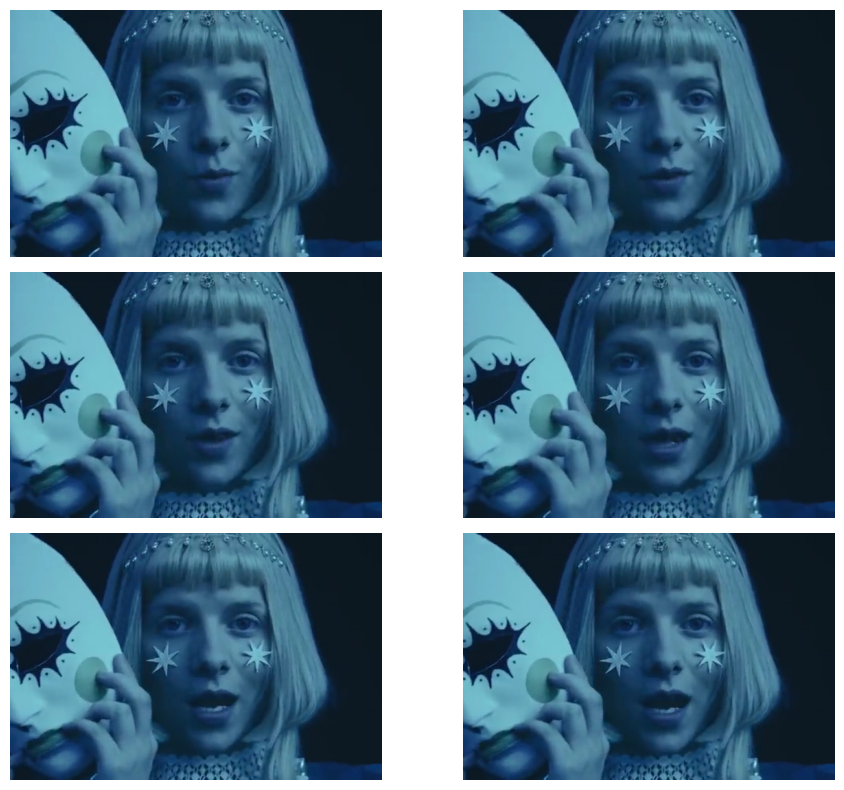

In [72]:
plt.figure(figsize=(10,8))

plt.subplot(321)
plt.imshow( cv.cvtColor(frames_of_interest[0], cv.COLOR_BGR2RGB) )
plt.axis('off')

plt.subplot(322)
plt.imshow( cv.cvtColor(frames_of_interest[1], cv.COLOR_BGR2RGB) )
plt.axis('off')

plt.subplot(323)
plt.imshow( cv.cvtColor(frames_of_interest[2], cv.COLOR_BGR2RGB) )
plt.axis('off')

plt.subplot(324)
plt.imshow( cv.cvtColor(frames_of_interest[3], cv.COLOR_BGR2RGB) )
plt.axis('off')

plt.subplot(325)
plt.imshow( cv.cvtColor(frames_of_interest[4], cv.COLOR_BGR2RGB) )
plt.axis('off')

plt.subplot(326)
plt.imshow( cv.cvtColor(frames_of_interest[5], cv.COLOR_BGR2RGB) )
plt.axis('off')

plt.tight_layout()
plt.show()

# Lukas Kanade

In [146]:
def lucas_kanade_step(frame1, frame2, window_size=15):
    # Convert frames to grayscale if they aren't already.
    if frame1.ndim > 2:
        frame1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
    if frame2.ndim > 2:
        frame2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    
    # Calculate spatial derivatives (Ix, Iy).
    Ix = cv.Sobel(frame1, cv.CV_64F, 1, 0, ksize=3)  # Shape: (w, h)
    Iy = cv.Sobel(frame1, cv.CV_64F, 0, 1, ksize=3)  # Shape: (w, h)
    
    # Calculate temporal derivative (It).
    It = frame2.astype(np.float64) - frame1.astype(np.float64)  # Shape: (w, h)

    ##print(f'shape of frames: {frame1.shape}, Ix={Ix.shape}, Iy={Iy.shape}, It={It.shape}')
    
    # Initialize output flow fields.
    u = np.zeros_like(frame1, dtype=np.float64)
    v = np.zeros_like(frame1, dtype=np.float64)
    
    # Calculate window offsets.
    w = window_size // 2
    
    # For each pixel (excluding borders).
    #for y in tqdm(range(w, frame1.shape[0]-w)):
    for y in range(w, frame1.shape[0]-w):
        for x in range(w, frame1.shape[1]-w):
            # Extract windows.
            Ix_window = Ix[y-w:y+w+1, x-w:x+w+1].flatten()
            Iy_window = Iy[y-w:y+w+1, x-w:x+w+1].flatten()
            It_window = It[y-w:y+w+1, x-w:x+w+1].flatten()
            
            # Construct A matrix and b vector.
            A = np.vstack([Ix_window, Iy_window]).T  # Shape: (N, 2).
            b = -It_window  # Shape: (N,).
            
            # Solve the system using least squares.
            eigenvals = np.linalg.eigvals(A.T @ A)
            abs_eigenvals = np.abs( eigenvals )
            ##print(f'eigenvalues shape: {eigenvals.shape}') # Shape: (2,)

            #ratio = eigenvals[0] / eigenvals[1]
            #if abs_eigenvals.min() < 1:
            #    print(f'eigenvalues are small: {eigenvals}')
            #elif ratio < 1e-3 or ratio > 1e3:
            #    print(f'eigenvalues are not of equal magnitude: {eigenvals}')

            if np.min(np.abs(np.linalg.eigvals(A.T @ A))) >= 1e-6:  # Check if system is well-conditioned
                flow = np.linalg.inv(A.T @ A) @ A.T @ b # Shape: (2,)
                ##print(f'shape of flow: {flow.shape}')
                u[y, x] = flow[0]
                v[y, x] = flow[1]
    
    return u, v

In [122]:
u, v = lucas_kanade_step(frames_of_interest[3], frames_of_interest[4])

shape of frames: (360, 542), Ix=(360, 542), Iy=(360, 542), It=(360, 542)


  0%|          | 0/346 [00:00<?, ?it/s]

In [119]:
def visualize_flow(frame, u, v, step=16):
    # Create figure and axes.
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
    
    # Plot original frame.
    ax1.imshow(frame, cmap='gray')
    ax1.set_title('Original Frame')
    ax1.set_axis_off()
    
    # Plot flow magnitude.
    flow_magnitude = np.sqrt(u**2 + v**2)
    normalized_flow = flow_magnitude / np.max(flow_magnitude)
    ax2.imshow(normalized_flow, cmap='gray')
    ax2.set_title('Flow Magnitude')
    ax2.set_axis_off()
    
    # Plot flow vectors.
    y, x = np.mgrid[step//2:frame.shape[0]:step, step//2:frame.shape[1]:step]
    u_subsampled = u[y, x]
    v_subsampled = v[y, x]
    
    # Create background for vectors.
    ax3.imshow(frame, cmap='gray')
    magnitude = np.sqrt(u_subsampled**2 + v_subsampled**2)
    ax3.quiver(x, y, u_subsampled, v_subsampled, 
        #magnitude,           # Color by magnitude
        angles='xy',
        scale_units='xy',
        scale=0.1,          # Decrease this to make vectors longer
        color='red',
        #cmap='viridis',    # Use a colormap
        width=0.002,        # Adjust arrow width
        headwidth=3,        # Make arrowhead wider
        headlength=3,       # Make arrowhead longer
        headaxislength=5,   # Make arrow head bigger
        minshaft=4)         # Minimum length of arrow shaft
    ax3.set_title('Flow Vectors')
    ax3.set_axis_off()
    
    plt.tight_layout()
    return fig

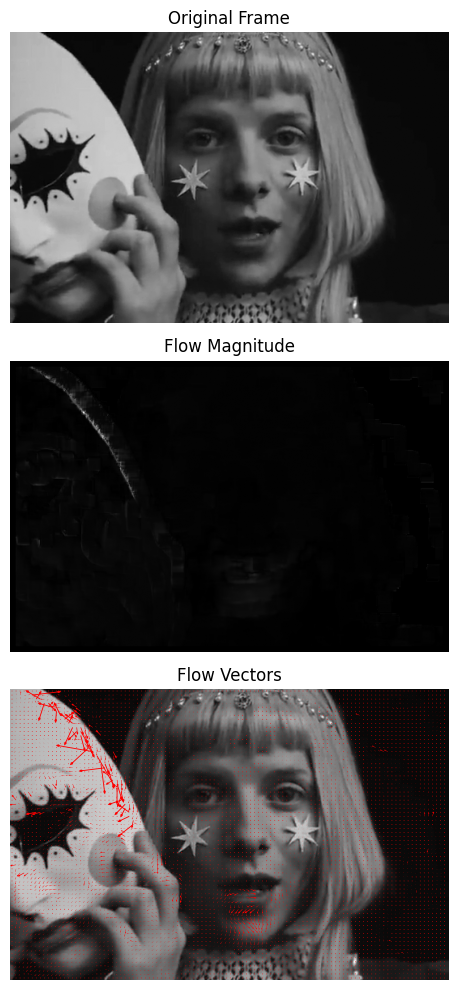

In [123]:
fig = visualize_flow(cv.cvtColor(frames_of_interest[3], cv.COLOR_BGR2GRAY), u, v, step=5)
plt.show()

In [125]:
len(frames_of_interest)

50

In [139]:
frames_of_interest = np.array( frames_of_interest )

In [147]:
flows = []
for i in tqdm(range(frames_of_interest.shape[0]-1)):
    u, v = lucas_kanade_step(frames_of_interest[i], frames_of_interest[i+1])
    flows.append((u, v))

  0%|          | 0/49 [00:00<?, ?it/s]

In [135]:
def visualize_multiple_flows(frames_of_interest, flows, step=8, figsize=(15, 10)):
    """
    Visualize optical flow for multiple frames in a 2x3 grid
    
    Parameters:
    frames_of_interest: list of frames to visualize
    flows: list of (u, v) tuples corresponding to each frame
    step: spacing between flow vectors
    figsize: size of the overall figure
    """
    
    # Create figure with 2x3 subplot grid.
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.ravel()  # Flatten axes array for easier indexing
    
    # For each frame and its corresponding flow
    for idx, (frame, (u, v)) in enumerate(zip(frames_of_interest, flows)):
        if idx >= 6:  # Only show first 6 frames.
            break

        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        
        # Create grid for subsampling.
        y, x = np.mgrid[step//2:frame.shape[0]:step, step//2:frame.shape[1]:step]
        u_subsampled = u[y, x]
        v_subsampled = v[y, x]
        
        # Plot on corresponding subplot.
        axes[idx].imshow(frame, cmap='gray')
        axes[idx].quiver(x, y, u_subsampled, v_subsampled,
            angles='xy',
            scale_units='xy',
            scale=0.1,
            color='red',
            width=0.002,
            headwidth=3,
            headlength=3,
            headaxislength=5,
            minshaft=4)
        
        axes[idx].set_title(f'Frame {idx+1}')
        axes[idx].set_axis_off()
    
    plt.tight_layout()
    return fig

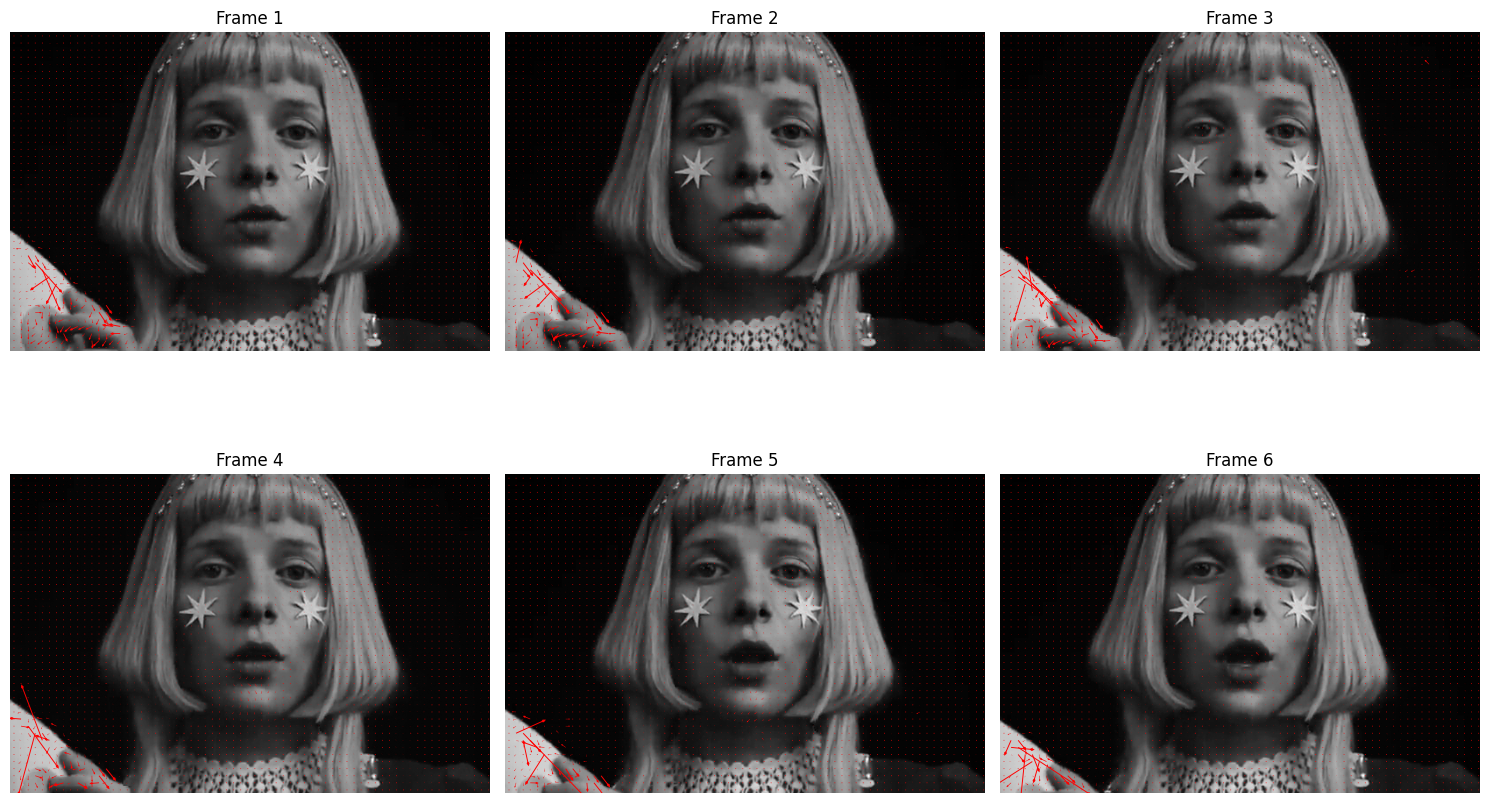

In [155]:
fig = visualize_multiple_flows(frames_of_interest[40:], flows[40:])
plt.show()